<a href="https://colab.research.google.com/github/simecek/PseudoDNA_Generator/blob/master/models/Exons_AWD_LSTM_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [2]:
!pip install fastai2>=0.0.11 ipywidgets matplotlib nbdev>=0.2.12 pandas scikit_learn sentencepiece

In [3]:
from fastai2.text.all import *
import pandas as pd
import torch

In [4]:
torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.get_device_name(0)

(True, 1, 'Tesla P100-PCIE-16GB')

In [5]:
# Mount to your Google Drive allowing lesson files will be saved to your Drive location
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
dt = pd.read_csv("/content/drive/My Drive/data/random/random_exons.csv")
dt.columns = ['chr', 'start', 'end', 'seq']
dt = dt[~dt.seq.str.contains("N")]   # just for sure

train = dt[dt.chr!="1"]
test = dt[dt.chr=="1"]

print(dt.shape, train.shape, test.shape)
dt.head()

(50000, 4) (45336, 4) (4664, 4)


,chr,start,end,seq
0,1,236763182,236763381,GACTACCCAAAAGATTTTTGGCACTTACAATTTTTAAAATAGTTTATGTCATCTCTTCATTATTTAGGGCTGGATGGTCAACTCAGTCAGTGATTTTTTGATGCTTCTCTTATCCTCCAGAATAGAGACCTAAGGACACGTGGAAGTCAGTTTAATTGCCAGAGAGAAGGATGCAATCACTAGGTAAAATGAGGTTTTTA
1,17,8289582,8289781,AGCCCCCGTAAGGAGGAAGGAACGGGCGGGTATCTCATGACTGGGTTCCCAGGAGAATCGGGCTGGGAGGGACAGAACAGGGAGACTCACTGGTGGGATCCTCCAAGGAAGCAGGAGTGGGCCAGAGGTTTGGGGTAACTGATACCCAGGTCCTCTGGGGAACAGGAATTGGCAATTTCCAAACCTCAGGCCTGGATGAT
2,3,100455979,100456178,TGAGCCCCAATTCACCATTTCAGGATGTGGATGGGGGCGGGGTTGGGGGTAAAAACAGCTATAAAAAGCAACTGCAGATGCTGACTGACTGCAGTGGGCAGGGTATGTAGCTGCTCCAAGATGACTTGCATCATACCCCAATTACTGCTGGCATCTTAGTTGAGAGTATAATCTGCTTGGTTGCCTTTTTATGGGAATAA
3,10,94852754,94852953,AGGGCCTGGCCCGCATGGAGCTGTTTTTATTCCTGACCTTCATTTTACAGAACTTTAACCTGAAATCTCTGATTGACCCAAAGGACCTTGACACAACTCCTGTTGTCAATGGATTTGCTTCTGTCCCGCCCTTCTATCAGCTGTGCTTCATTCCTGTCTGAAGAAGCACAGATGGTCTGGCTGCTCCTGTGCTGTCCCTG
4,1,209756085,209756284,GGGTTTGCGAACCTTGTGGCTTTGTCTGTTTCCTGTTTCAGCAAGGCTGCTGTGCAAAAAGAAAGACGGTACCAAGAAGGGACGTGTTAATGGGGCCCAGACCTATGGATTGAAAGCGTGTGCTTTACCCATCTGCTGTCTTGCTCCATCTGAGACCAGAGCCAAGATCTGCCCAGGACTGGAATGCTTTCCCGAGTGGC


In [7]:
!rm -rf split_tok

!rm -rf split
!mkdir split
!mkdir split/train
!mkdir split/valid
!mkdir split/train/1/
!mkdir split/valid/1/

In [8]:
# splitting the file into training and test part
N = len(dt.seq)

for i, s in enumerate(train.seq):
  open("split/train/1/seq"+str(i)+".txt", 'w').writelines([s])
for i, s in enumerate(test.seq):
  open("split/valid/1/seq"+str(i)+".txt", 'w').writelines([s])

## Tokenizer

In [9]:
!wget https://raw.githubusercontent.com/simecek/PseudoDNA_Generator/master/models/genomic_tokenizer2.py

--2020-06-27 18:27:47--  https://raw.githubusercontent.com/simecek/PseudoDNA_Generator/master/models/genomic_tokenizer2.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 565 [text/plain]
Saving to: ‘genomic_tokenizer2.py’

genomic_tokenizer2. 100%[===================>]     565  --.-KB/s    in 0s      

2020-06-27 18:27:47 (33.5 MB/s) - ‘genomic_tokenizer2.py’ saved [565/565]



In [10]:
from genomic_tokenizer2 import tkn2

## Data Loaders

In [11]:
dls_lm = TextDataLoaders.from_folder(Path("./split"), bs=128, seed=42, 
                                   is_lm=True, 
                                   tok_tfm=tkn2, seq_len=50)

In [12]:
dls_lm.show_batch()

,text,text_
0,A A T G T A A G A G G C A C C A G A G G A T T C C T G C T C T G T C C C C T G G T T T G C G G C T T,A T G T A A G A G G C A C C A G A G G A T T C C T G C T C T G T C C C C T G G T T T G C G G C T T G
1,T T C T A A G C T A C A T A A A T T A A G A T A T C C A C T G G A C T G G A A A C T A T C A A T T T,T C T A A G C T A C A T A A A T T A A G A T A T C C A C T G G A C T G G A A A C T A T C A A T T T G
2,C G C G G T C A G C G G C C A G G C A G T C C T G A G G A G G C C G C T G C C C T A G T C G A A G G,G C G G T C A G C G G C C A G G C A G T C C T G A G G A G G C C G C T G C C C T A G T C G A A G G A
3,A A A A T T A C C T A G T C T A C C A A G A A A A T A C A A A A A C A T A A G G C T G T A A G T A A,A A A T T A C C T A G T C T A C C A A G A A A A T A C A A A A A C A T A A G G C T G T A A G T A A A
4,A G T A T T A A A A A T C C A A A G C T T T A A A T T A G A A A A T G G G C A A A A G T C A T G A A,G T A T T A A A A A T C C A A A G C T T T A A A T T A G A A A A T G G G C A A A A G T C A T G A A A
5,T G T A G G C T T C T T T T G A C T A G T C A C T G G C A T G G C C A C A A T C T G A A T T T G G G,G T A G G C T T C T T T T G A C T A G T C A C T G G C A T G G C C A C A A T C T G A A T T T G G G A
6,G G A G T T C G A A A T C A G C C T G G C C A A C A T G G T G A A A C T C C G C C T C T A C T A A A,G A G T T C G A A A T C A G C C T G G C C A A C A T G G T G A A A C T C C G C C T C T A C T A A A A
7,A T T A T G A C T A G G T C T A T A A T T T A A T A A C A A G T C A C A A T A T C T C T C T T T C T,T T A T G A C T A G G T C T A T A A T T T A A T A A C A A G T C A C A A T A T C T C T C T T T C T T
8,A A G C A G G C T G G T T C A C T C A C T T G G C A G T C A C T G G G C G G C T A T T C T T G T G C,A G C A G G C T G G T T C A C T C A C T T G G C A G T C A C T G G G C G G C T A T T C T T G T G C C


## Model and Learning

In [13]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, pretrained=False, 
    metrics=[accuracy, Perplexity()])

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.0006918309954926372)

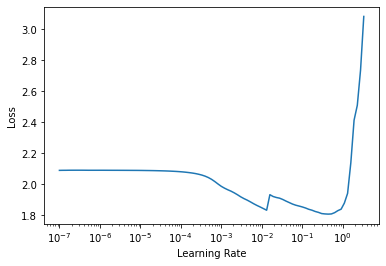

In [14]:
learn.lr_find()

In [15]:
learn.fit_one_cycle(5, 0.05)
learn.export("/content/drive/My Drive/DNAModels/Exons/Exons_AWD_LSTM_v1.pkl")

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.328912,1.323811,0.349938,3.757716,05:48
1,1.322950,1.321861,0.352252,3.750393,05:38
2,1.322914,1.320645,0.354841,3.745836,05:39
3,1.320869,1.318369,0.356201,3.737319,05:39
4,1.319773,1.316948,0.357593,3.732014,05:40
